In [364]:

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np # linear algebra
import pandas as pd # data processing,
import math
import datetime
import platform



In [365]:
# data processing
train_data = pd.DataFrame(pd.read_csv("data/handwriting_training_set.txt"))
train_labels = pd.DataFrame(pd.read_csv("data/handwriting_training_set_labels.txt"))
test_data = pd.DataFrame(pd.read_csv("data/handwriting_test_set.txt"))
test_labels = pd.DataFrame(pd.read_csv("data/handwriting_test_set_labels.txt"))


In [366]:
print('train_data:', train_data.shape)
print('train_labels:', train_labels.shape)
print('test_data:', test_data.shape)
print('test_labels:', test_labels.shape)


train_data: (3999, 400)
train_labels: (3999, 1)
test_data: (999, 400)
test_labels: (999, 1)


In [367]:
X = train_data.iloc[:, 0:400]
y = train_labels.iloc[:, 0]
X_test = test_data.iloc[:, 0:400]

Visualizing the data using TSNE:

In [368]:
X_tsn = X/255

from sklearn.manifold import TSNE
tsne = TSNE()

tsne_res = tsne.fit_transform(X_tsn)

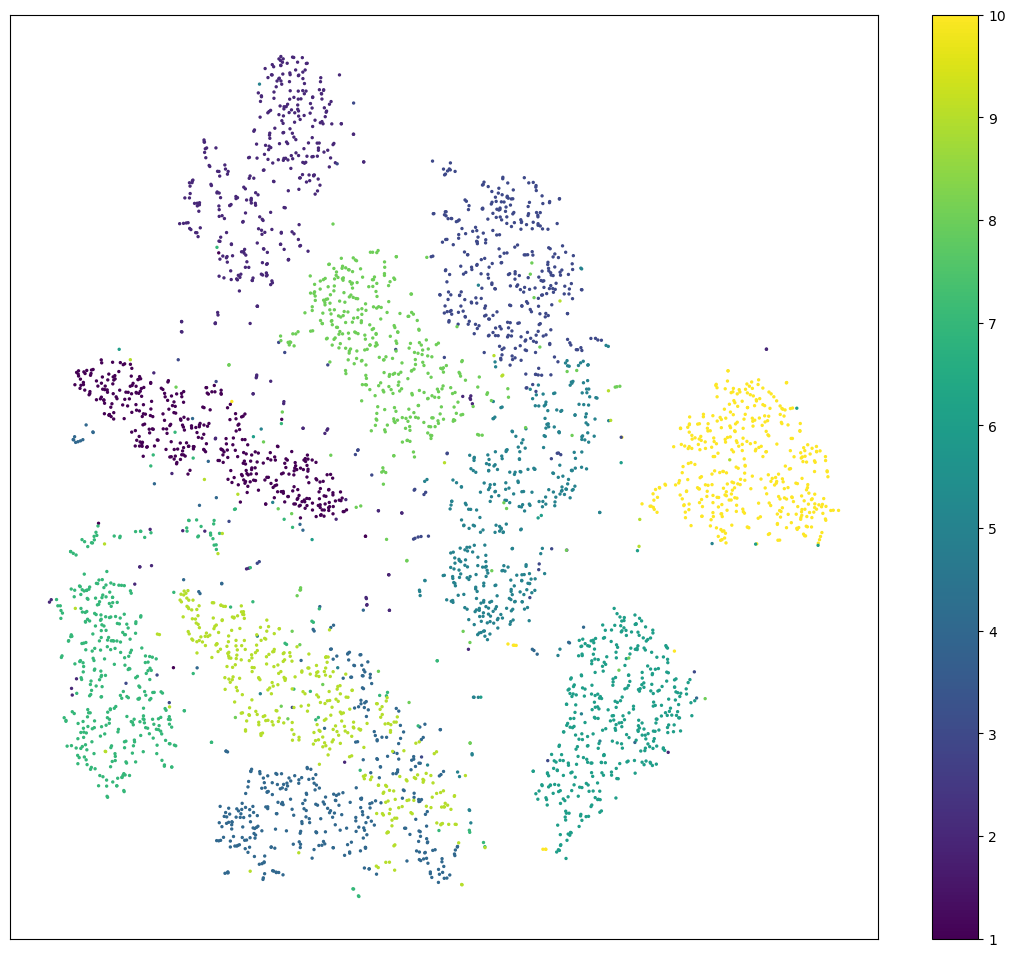

In [369]:
plt.figure(figsize=(14, 12))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y, s=2)
plt.xticks([])
plt.yticks([])
plt.colorbar();

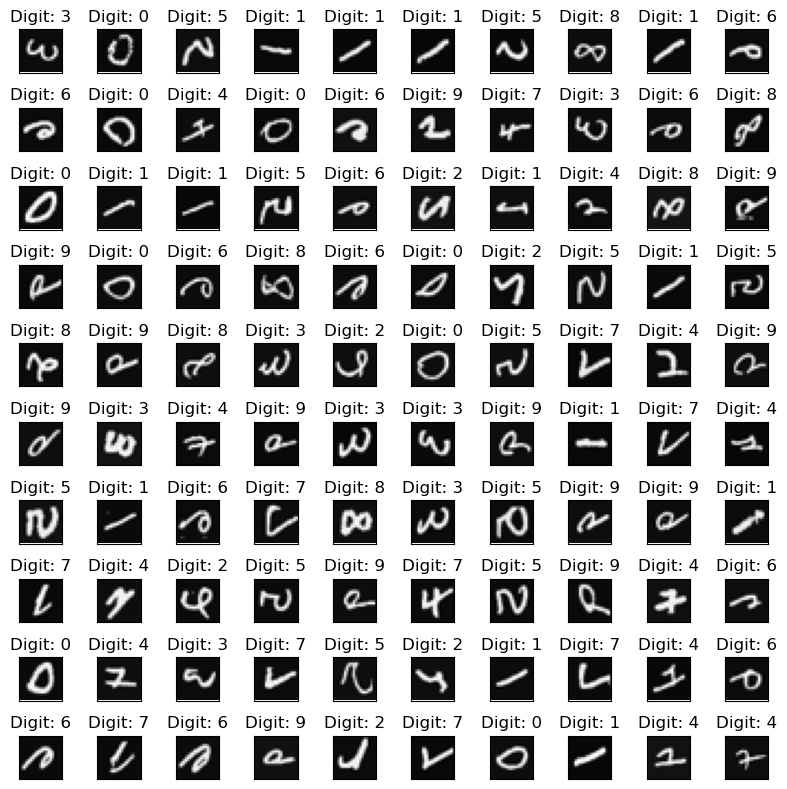

In [370]:
# img plot: before training

train_data = np.loadtxt("data/handwriting_training_set.txt", delimiter=",")
train_labels = np.loadtxt("data/handwriting_training_set_labels.txt")
train_labels[train_labels == 10] = 0

# Display 100 random images
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    # Select a random image
    random_idx = np.random.randint(train_data.shape[0])
    random_img = train_data[random_idx, :]
    
    # Reshape the vector into a 20x20 matrix
    img_matrix = np.reshape(random_img, (20, 20))
    
    # Display the image and set the title
    ax.imshow(img_matrix, cmap='gray')
    ax.set_title('Digit: {}'.format(int(train_labels[random_idx])))
    
    # Remove the x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

#### SVD:
+ Note: the V matrix contains the principal components of the data, which are the directions in which the data varies the most. By selecting the first k columns of the V matrix (i.e., the k singular vectors with the largest singular values), we like to obtain a low-dimensional representation of the data that captures the most important variations in the data. This low-dimensional representation can then be used to classify the test examples by computing the residual error between the test examples and the projected class bases(eigenvectors for k).


In [371]:
# A. Algorithm for Classification of Handwritten Digits using SVD:

# data processing
X_train = np.loadtxt("data/handwriting_training_set.txt", delimiter=",")
y_train = np.loadtxt("data/handwriting_training_set_labels.txt")
X_test = np.loadtxt("data/handwriting_test_set.txt", delimiter=",")
y_test = np.loadtxt("data/handwriting_test_set_labels.txt")


# Replace label values of 10 with 0
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

# Divide training set into 10 classes based on labels
classes = []
for i in range(10):
    class_i = X_train[y_train == i]
    classes.append(class_i)

# Compute SVD of each class matrix
k_values = [5, 10, 15, 20]  # values of k to use
class_bases = []
for class_i in classes:
    # Compute mean image
    mean_image = np.mean(class_i, axis=0)
    # Subtract mean image from each training example
    diff = class_i - mean_image
    # Compute SVD
    #The U and S matrices obtained from the SVD are not being used: the primary goal of the code is to find a low-dimensional representation of the data using the V matrix.
    _, _, vT = np.linalg.svd(diff)
    # Store first k singular vectors as basis for class
    bases = vT[:k_values[-1]].T
    class_bases.append(bases[:, :k_values[-1]])


# B. Two-Stage Algorithm for Classification of Handwritten Digits: 
# Classify test examples
for k in k_values:
    correct = 0
    for i in range(len(X_test)):
        x = X_test[i]
        # Compute residual error for each class
        errors = []
        for j in range(10):
            diff = x - np.mean(classes[j], axis=0)
            proj = np.dot(diff, class_bases[j][:, :k])
            recon = np.dot(proj, class_bases[j][:, :k].T) + np.mean(classes[j], axis=0)
            error = np.linalg.norm(x - recon)
            errors.append(error)
        # Classify test example as digit with smallest residual error
        pred = np.argmin(errors)
        if pred == int(y_test[i]):
            correct += 1
    print(f'Accuracy using {k} singular vectors: {correct/len(X_test):.2%}')
    

Accuracy using 5 singular vectors: 93.00%
Accuracy using 10 singular vectors: 94.70%
Accuracy using 15 singular vectors: 95.40%
Accuracy using 20 singular vectors: 96.00%


In [372]:
# Classify test examples
digit_correct = np.zeros(10)
digit_total = np.zeros(10)
for k in k_values:
    correct = np.zeros(10)
    total = np.zeros(10)
    for i in range(len(X_test)):
        x = X_test[i]
        # Compute residual error for each class
        errors = []
        for j in range(10):
            diff = x - np.mean(classes[j], axis=0)
            proj = np.dot(diff, class_bases[j][:, :k])
            recon = np.dot(proj, class_bases[j][:, :k].T) + np.mean(classes[j], axis=0)
            error = np.linalg.norm(x - recon)
            errors.append(error)
        # Classify test example as digit with smallest residual error
        pred = np.argmin(errors)
        # Check if classification is correct and update counts
        if pred == int(y_test[i]):
            correct[int(y_test[i])] += 1
            digit_correct[int(y_test[i])] += 1
        total[int(y_test[i])] += 1
        digit_total[int(y_test[i])] += 1

# Print accuracy for each digit
print('Accuracy for each digit:')
for i in range(10):
    acc = digit_correct[i] / digit_total[i]
    print(f'Digit {i}: {acc:.2%}')
print()




Accuracy for each digit:
Digit 0: 99.75%
Digit 1: 98.75%
Digit 2: 90.00%
Digit 3: 93.50%
Digit 4: 95.50%
Digit 5: 93.75%
Digit 6: 98.00%
Digit 7: 94.50%
Digit 8: 89.00%
Digit 9: 95.00%



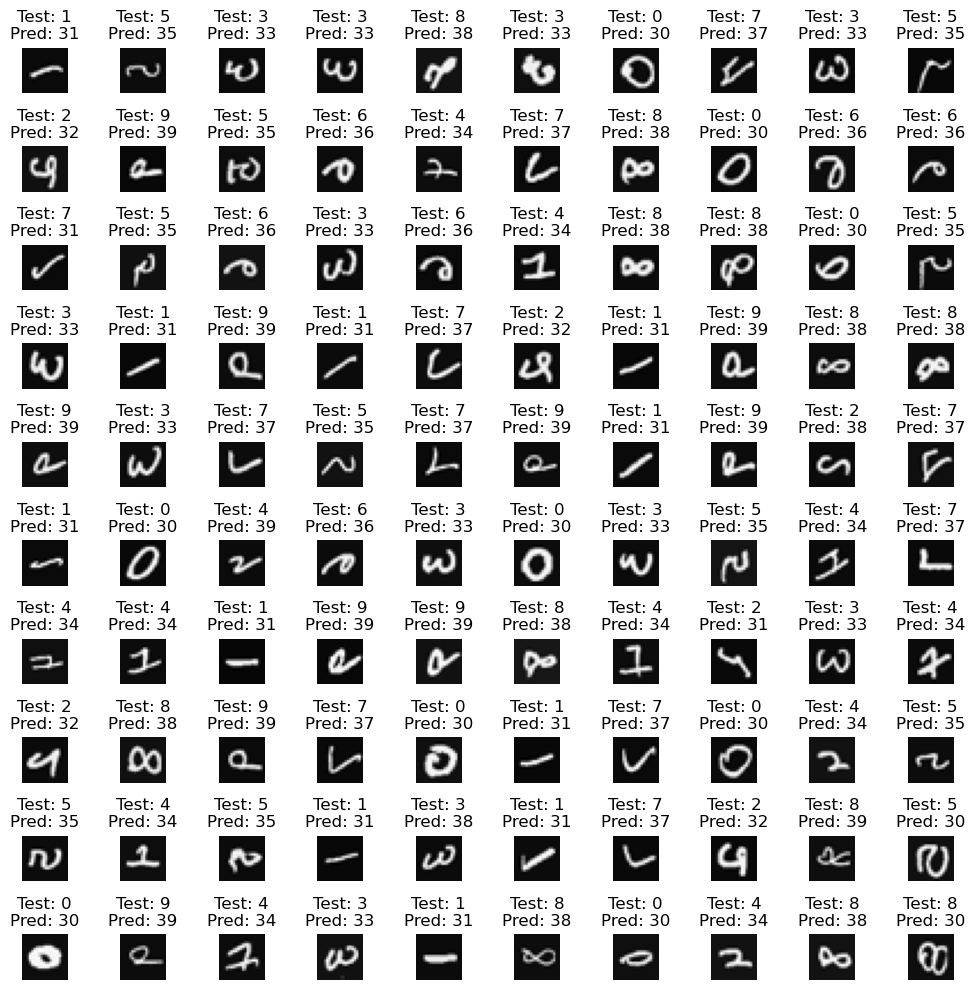

In [373]:
import matplotlib.pyplot as plt

# Select random test examples
random_idxs = np.random.choice(len(X_test), size=100, replace=False)

# Create plot
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        # Get index of current test example
        idx = random_idxs[i*10+j]
        # Get test label and predicted label
        test_label = int(y_test[idx])
        errors = []
        for k in k_values:
            x = X_test[idx]
            # Compute residual error for each class
            for l in range(10):
                diff = x - np.mean(classes[l], axis=0)
                proj = np.dot(diff, class_bases[l][:, :k])
                recon = np.dot(proj, class_bases[l][:, :k].T) + np.mean(classes[l], axis=0)
                error = np.linalg.norm(x - recon)
                errors.append(error)
            # Classify test example as digit with smallest residual error
            pred = np.argmin(errors)
            # i am doing something wrong: pre has 3 ??
            #axs[i, j].set_title(f'Test: {test_label}\nPred: {str(pred)[0]}')
            axs[i, j].set_title(f'Test: {test_label}\nPred: {pred}')
        # Plot test example
        axs[i, j].imshow(X_test[idx].reshape(20, 20), cmap='gray')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()
